# Advanced lane finding using OpenCV

## 1. Camera Calibration

Our initial goal is to obtain a transformation matrix to map a 3D object to a 2D image and a set of coefficients representative of the distortion due to the optics and setting of the image capturing device. Let's import first the main libraries used for this project:


In [1]:
import time
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
#qt inline
%matplotlib inline

nx = 9 # number of inside corners in x
ny = 6 # number of inside corners in y

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

The camera calibration function receives a set of images from a source and uses cv2.calibrateCamera to obtain the calibration matrix and distortion coefficients

In [2]:
def camera_calibration(images, nx, ny):
    
    # Prepare object points in the format (0,0,0), (0,1,0),..., (8,8,0)
    objp =  np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) # x and y coordinates. z value is zero for all points

    # Arrays to store object and image points for all the images
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane
    
    # Step through the list and search for chess corners
    count = 1
    for fname in images:
        img = cv2.imread(fname)
        
        # Convert image to gray scale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        
        if ret ==  True:
            objpoints.append(objp)
            imgpoints.append(corners)
        
    ret, mtx, dist, rvec, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return mtx, dist

mtx , dist = camera_calibration(images,nx,ny)

# 2. Distortion correction

The following procedure distort the image and apply color/gradient threshold to clearly identify the lane lines

In [3]:
def undistort_image(img, mtx, dist):
    #1. Undistort using mtx and dist
    undist = cv2.undistort(img, mtx, dist, None, mtx)
        
    return undist


## Example of the results so far.

Let's undistort a chessboard image using the matrix and distortion coefficients obtained after camera calibration.

In [4]:
img = mpimg.imread('camera_cal/calibration5.jpg')

undist = undistort_image(img, mtx, dist)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
ax1.set_title('Original image ', fontsize=50)
ax1.imshow(img)

ax2.set_title('Undistorted image', fontsize=50)
ax2.imshow(undist)

# 3. Color and gradient thresholds

In [18]:
def threshold_function(img):
    
    # Transforms image to the HLS color space 
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # Transforms image to the HSV color space 
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV) 
    
    # Define saturation and lightness channel in separata variables
    s_channel = hls[:,:,2] # Takes the saturation channel from the image in HLS color space
    l_channel = hls[:,:,1] # Takes the lightness channel from the image in HLS color space
    v_channel = hsv[:,:,2]
    s2_channel =  hsv[:,:,1]
    
    # Threshold over gradient: Sobel x in the lightness channel 
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in the x direction
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(sobelx))
    
    #Threshold x gradient
    thresh_min = 30
    thresh_max = 255
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= thresh_min) & (scaled_sobelx < thresh_max)] = 1
    
    # Threshold over color: Saturation channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s2_channel)
    s_binary[(s_channel >= s_thresh_min)&( s_channel < s_thresh_max)] = 1
    
    # Stack both channels to see their individual contributions as blue (saturation channel) and green (sobel x)
    color_binary = np.dstack((np.zeros_like(s_channel), sxbinary, s_binary ))*255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(sxbinary==1) | (s_binary==1)] = 1
    
    return combined_binary


## Color and gradient thresholds output

In [19]:
img = mpimg.imread('test_images/test1.jpg')

binary_output=threshold_function(img)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
ax1.set_title('Stacked thresholds', fontsize=50)
ax1.imshow(img)

ax2.set_title('Binary image combined thresholds', fontsize=50)
ax2.imshow(binary_output, cmap='gray')
plt.show()

# 4. Perspective transform

Based on previous modifications of the original image now we apply a perspective transform. Our goal is to see the real nature of the lanes as seen from the top down. Lanes should be parallel and clear on the final result

In [20]:
def perspective_transform(img):
    
    # x and y image sizes
    img_size = (img.shape[1], img.shape[0])

    offset_left = 245 # offset in x direction at the left side of the warped image
    offset_right = 285 # offset in the x directions at the right side of the warped image

    #b. Define four source points src=np.float32([[,],[,],[,],[,]])
    src = np.float32([[206,img_size[1]], [582,460], [701,460], [1100,img_size[1]]])

    #c. Define four destination points dst=np.float32([[,],[,],[,],[,]])
    dst = np.float32([[offset_left,img_size[1]],[offset_left,0],[img_size[0]-offset_right,0],[img_size[0]-offset_right,img_size[1]]])

    #d. Get perspective transform M using the source and destination points
    M = cv2.getPerspectiveTransform(src, dst)
    
    #e. Get the inverse perspective transform Minv using the destination and source points
    Minv = cv2.getPerspectiveTransform(dst,src)
    
    #f. Warp the image captured by the camera using this transform to get an accurate depiction of the 2D image
    warped = cv2.warpPerspective(img, M,  img_size, flags=cv2.INTER_LINEAR)
    #options: cv2.INTER_NEAREST
    
    return warped, M, Minv


## Implementation of the perspective transform

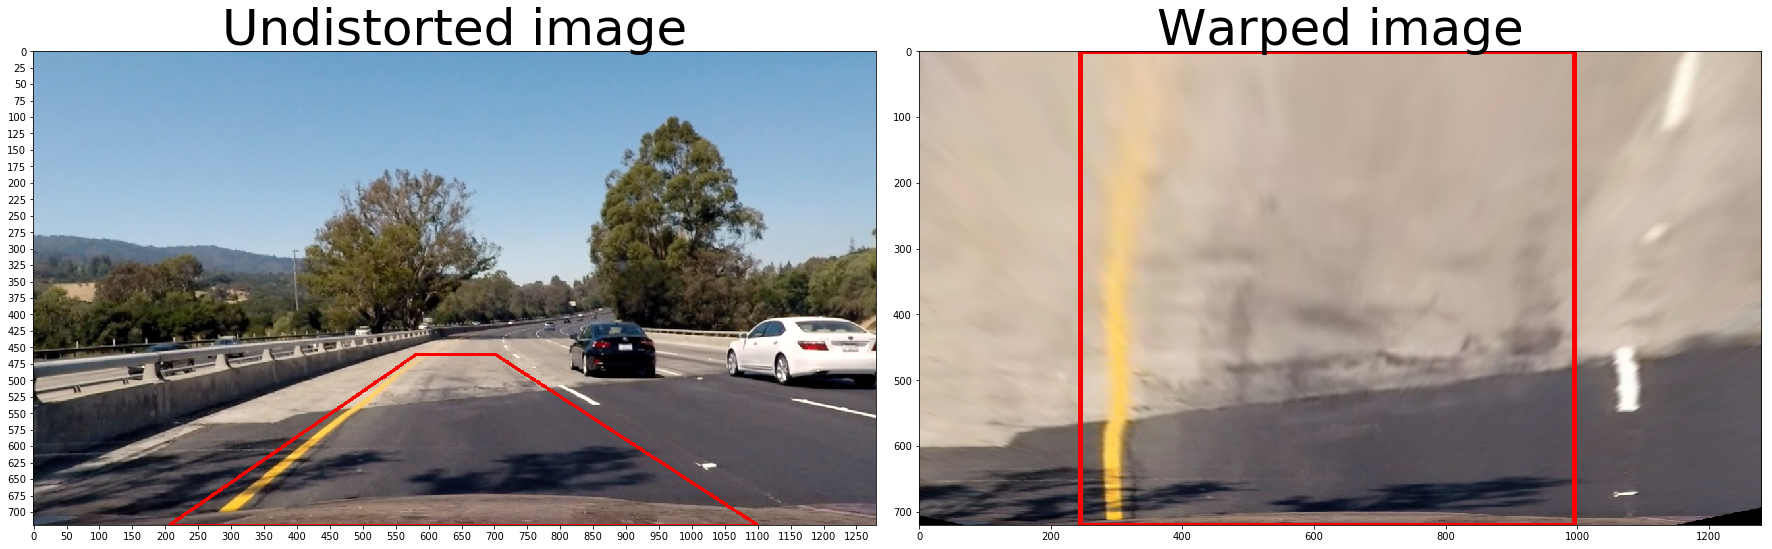

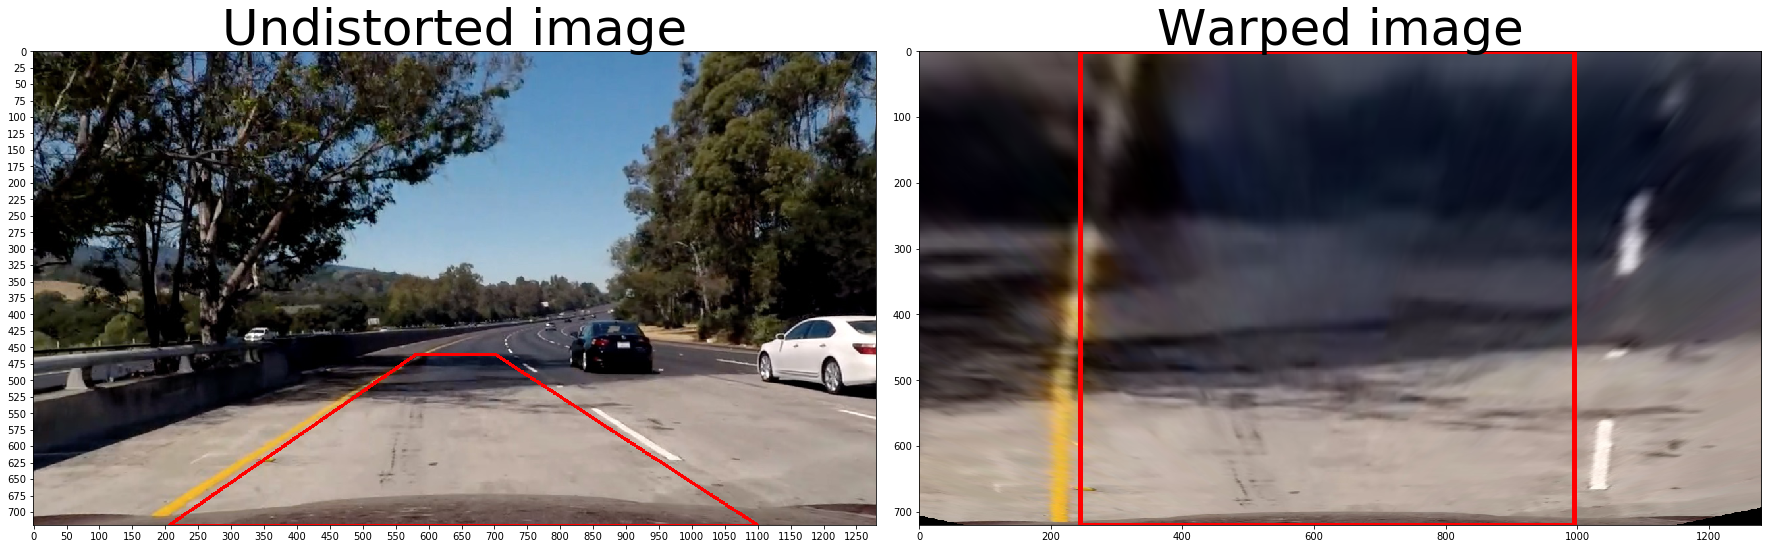

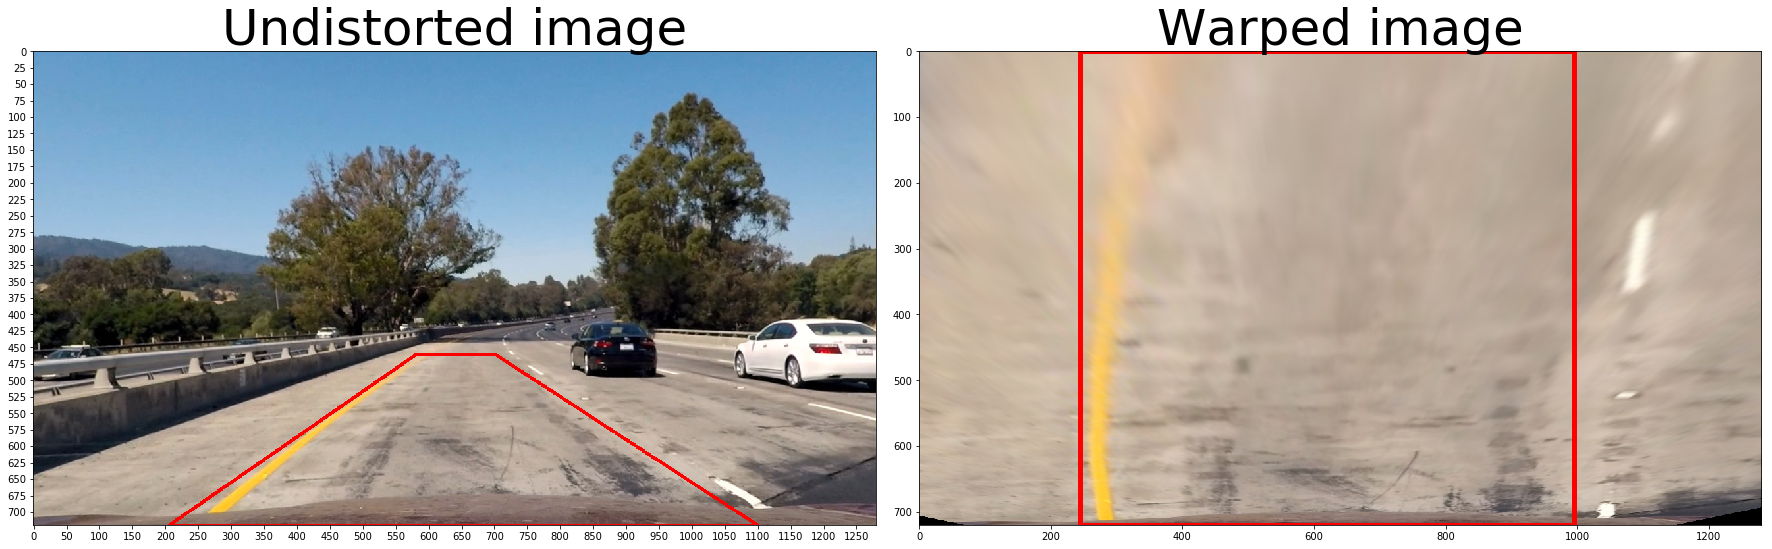

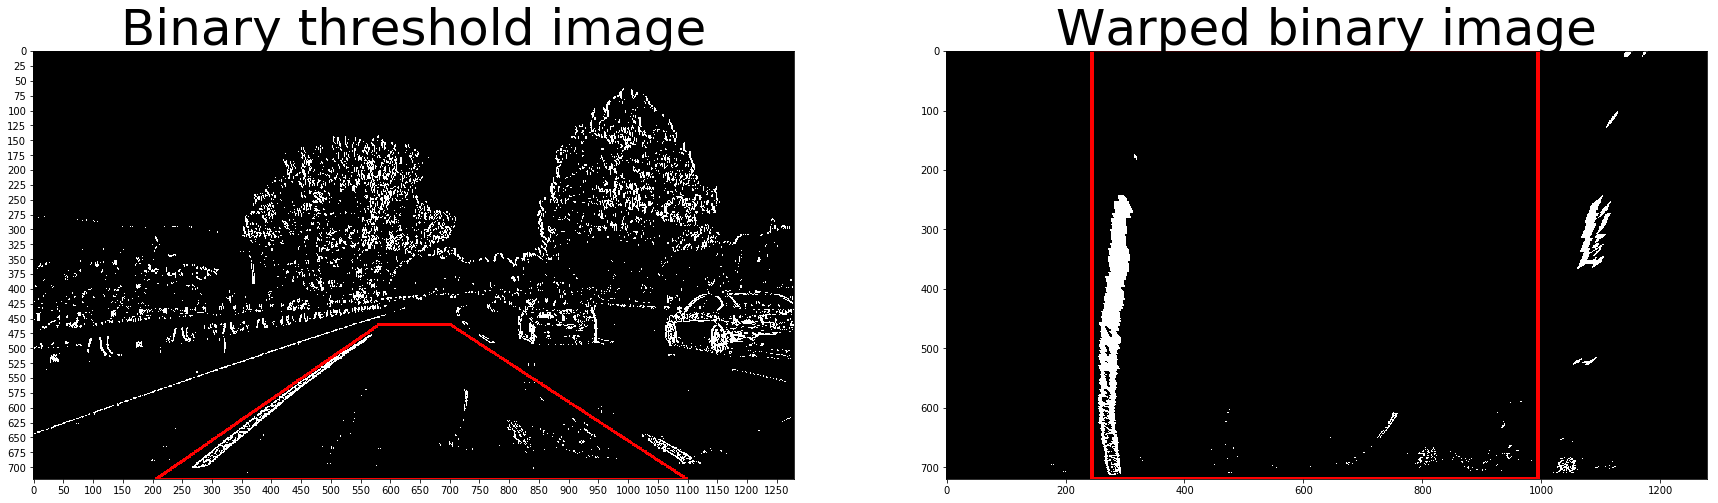

In [21]:
#images = glob.glob('test_images/test*.jpg')
images = ['test_images/test4.jpg','test_images/test5.jpg','test_images/test1.jpg']#'test_images/test5.jpg']#'test_images/straight_lines1.jpg']

for fname in images:
    img = mpimg.imread(fname)

    # Undistorted image
    undist = undistort_image(img, mtx, dist)
    
    # Combine binary image after the application of gradient in x direction and saturation channel thresholds
    img_thresh = threshold_function(undist)
    
    # x and y image sizes
    img_size = (img.shape[1], img.shape[0])
    offset_left = 245 # offset in x direction at the left side of the warped image
    offset_right = 285 # offset in the x directions at the right side of the warped image
    #b. Define four source points src=np.float32([[,],[,],[,],[,]])
    src = np.float32([[206,img_size[1]], [582,460], [701,460], [1100,img_size[1]]])
    #c. Define four destination points dst=np.float32([[,],[,],[,],[,]])
    dst = np.float32([[offset_left,img_size[1]],[offset_left,0],[img_size[0]-offset_right,0],[img_size[0]-offset_right,img_size[1]]])

    # Warped image using perspective transform over the undistorted image
    warped, perspective_M, Minv = perspective_transform(undist)
    
    # Warped binary image using perspective transform over the combined threshold binary image
    binary_warped, perspective_M, Minv = perspective_transform(img_thresh)
    
    
    binary_lines = np.dstack((img_thresh, img_thresh, img_thresh))*255

    for i in range(len(src)):
        if i==(len(src)-1):
            cv2.line(undist,tuple(src[0]), tuple(src[i]),(255,0, 0), thickness=3, lineType=8)
            cv2.line(binary_lines,tuple(src[0]), tuple(src[i]),(255,0, 0), thickness=3, lineType=8)
        else:
            cv2.line(undist,tuple(src[i]), tuple(src[i+1]),(255,0, 0), thickness=3, lineType=8)
            cv2.line(binary_lines,tuple(src[i]), tuple(src[i+1]),(255,0, 0), thickness=3, lineType=8)
    
    warped_lines = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    for i in range(len(dst)):
        if i==(len(dst)-1):
            cv2.line(warped,tuple(dst[0]), tuple(dst[i]),(255,0, 0), thickness=5, lineType=8)
            cv2.line(warped_lines,tuple(dst[0]), tuple(dst[i]),(255,0, 0), thickness=5, lineType=8)
        else:
            cv2.line(warped,tuple(dst[i]), tuple(dst[i+1]),(255,0, 0), thickness=5, lineType=8)
            cv2.line(warped_lines,tuple(dst[i]), tuple(dst[i+1]),(255,0, 0), thickness=5, lineType=8)
        
    
    # Plotting undistorted image and warped image
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
    f.tight_layout()
    ax1.set_title('Undistorted image', fontsize=50)
    ax1.set_xticks(np.arange(0, undist.shape[1], step=50))
    ax1.set_yticks(np.arange(0, undist.shape[0], step=25))
    ax1.imshow(undist)
    ax2.set_title('Warped image', fontsize= 50)
    ax2.imshow(warped)
    plt.subplots_adjust(left = 0., right = 1, top=0.9, bottom = 0.)
    plt.show()
    # Plotting binary threshold image and warped binary image
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
    ax1.set_title('Binary threshold image', fontsize=50)
    ax1.set_xticks(np.arange(0, undist.shape[1], step=50))
    ax1.set_yticks(np.arange(0, undist.shape[0], step=25))
    ax1.imshow(binary_lines)

    ax2.set_title('Warped binary image', fontsize=50)
    ax2.imshow(warped_lines)

# 5. Detect lane lines

Here we find the lane lines using histograms and sliding window techniques. We start from the bottom of the image and move upwards trying to map peaks of the histogram to the most populated active pixels in each window. The following segment shows the functions used to detect the lane lines.

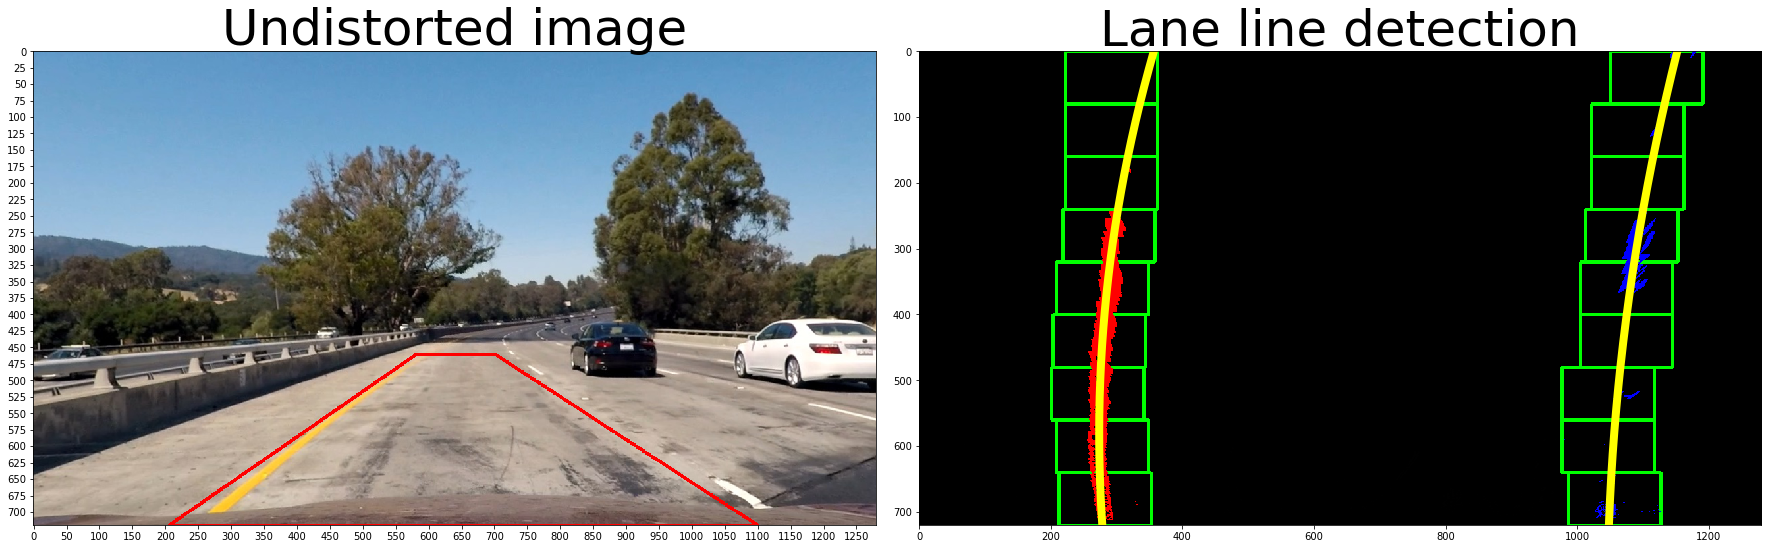

In [22]:
# Find a set of pixels part of the left and right lane when no previous lanes have been identified
def find_lane_pixels_prior(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 70
    # Set minimum number of pixels found to recenter window
    minpix = 40

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### 1. Find the four boundaries of the left and right window ###
        win_xleft_low = leftx_current - margin 
        win_xleft_high = leftx_current + margin  
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 4) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 4) 
        
        ### 2. Identify the nonzero pixels in x and y within the window ###
        good_left_inds = []
        good_right_inds = []
       
        for i in range(len(nonzerox)):
            
            if nonzerox[i]> binary_warped.shape[1]:
                print(i, nonzerox[i])
                continue
            # Add nonzero pixels within the windows in left line
            if (nonzerox[i]<win_xleft_high and nonzerox[i]>=win_xleft_low) and \
                (nonzeroy[i]<win_y_high and nonzeroy[i]>=win_y_low):    
                good_left_inds += [i]
            # Add nonzero pixels within the windows in right line    
            if (nonzerox[i]<win_xright_high and nonzerox[i]>=win_xright_low) and \
                (nonzeroy[i]<win_y_high and nonzeroy[i]>=win_y_low):    
                good_right_inds += [i]
        
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        
        ### 3. If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        # Left window
        nleft = 0
        leftx_sum = 0
        for i in good_left_inds:
            nleft +=  1
            leftx_sum += nonzerox[i]
        if nleft > minpix:
            leftx_current =  leftx_sum//nleft

        # Right window
        nright = 0
        rightx_sum = 0
        for i in good_right_inds:
            nright +=  1
            rightx_sum += nonzerox[i]
        if nright > minpix:
            rightx_current =  rightx_sum//nright
    

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        print('Something went wrong with the concatenation step!\n')
        pass
    
    # Extract left and right line pixel positions
    leftx = nonzerox[np.uint(left_lane_inds)]
    lefty = nonzeroy[np.uint(left_lane_inds)] 
    rightx = nonzerox[np.uint(right_lane_inds)]
    righty = nonzeroy[np.uint(right_lane_inds)]

    return leftx, lefty, rightx, righty, out_img
    
#Fit a set of pixel coordinates found in a image to a 2nd degree polynomial
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels_prior(binary_warped)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/750 # meters per pixel in x dimension
    
    ### 4. Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    left_fit_cr = np.polyfit(ym_per_pix*ploty, xm_per_pix*left_fitx, 2)
    right_fit_cr = np.polyfit(ym_per_pix*ploty, xm_per_pix*right_fitx, 2)
    
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    ax2.plot(left_fitx, ploty,linewidth=8, color='yellow',)
    ax2.plot(right_fitx, ploty,linewidth=8, color='yellow')
    
    
    # Here we calculate the left and right lanes x coordinate at the bottom of the undistorted image
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    left_fitx = np.uint(np.abs(left_fitx))
    right_fitx = np.uint(np.abs(right_fitx))
    
    # Get the indices for which the fix <= limit
    left_indices = np.argwhere(left_fitx < binary_warped.shape[1])
    right_indices = np.argwhere(right_fitx < binary_warped.shape[1])
        
    color_warp[np.uint(ploty[left_indices]),left_fitx[left_indices]] = [0,255,0]
    color_warp[np.uint(ploty[right_indices]),right_fitx[right_indices]] = [0,255,0]
    
     # Warp the blank back to original image space using inverse perspective matrix (Minv)
    color_unwarped = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    
    single_unwarped = color_unwarped[:,:,1]
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = single_unwarped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Get the indices fro which the y value is max in the binary image
    max_y_indices = np.argwhere(nonzeroy == np.amax(nonzeroy))
    # Values of x at the bottom of the image in the region between the lanes
    xvals = nonzerox[max_y_indices]
    
    left_x = np.min(xvals)
    right_x = np.max(xvals)
    
    return left_fitx, right_fitx, left_fit_cr, right_fit_cr, left_x, right_x, out_img

# Plotting undistorted image and warped image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
f.tight_layout()

left_fitx, right_fitx, left_fit_cr, right_fit_cr, left_x, right_x, out_img= fit_polynomial(binary_warped)

ax1.set_title('Undistorted image', fontsize=50)
ax1.set_xticks(np.arange(0, undist.shape[1], step=50))
ax1.set_yticks(np.arange(0, undist.shape[0], step=25))
ax1.imshow(undist)
ax2.set_title('Lane line detection', fontsize= 50)
ax2.imshow(out_img)
plt.subplots_adjust(left = 0., right = 1, top=0.9, bottom = 0.)
plt.show()

# 6. Determine the lane curvature and vehicle position


In [23]:
def curvature_position_estimation(binary_warped,left_fit_cr, right_fit_cr, left_x, right_x):
    '''
    Calculates the curvature of polynomial functions and the 
    vehicle position from the center of the lanes in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension in warped space
    xm_per_pix = 3.7/750 # meters per pixel in x dimension in warped space
    
    xm_per_pix_cam = 3.7/(1100-206) # meters per pixel in x dimension in camera space
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = ym_per_pix*np.max(ploty)
    
    ##### Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1+(2*left_fit_cr[0]*y_eval+left_fit_cr[1])**2)**1.5)/np.abs(2*left_fit_cr[0]) 
    right_curverad = ((1+(2*right_fit_cr[0]*y_eval+right_fit_cr[1])**2)**1.5)/np.abs(2*right_fit_cr[0])
    
    #x position of the car in the road
    real_midpoint_x = (binary_warped.shape[1]//2)
    
    #x coordinate of middle point of the lanes
    lane_center_x = (right_x+left_x)//2 
    
    #Distance of the car from the center of the lanes
    distance_from_center = (real_midpoint_x-lane_center_x)*xm_per_pix_cam
    
    return left_curverad, right_curverad, distance_from_center

## Testing curvature and position estimation function

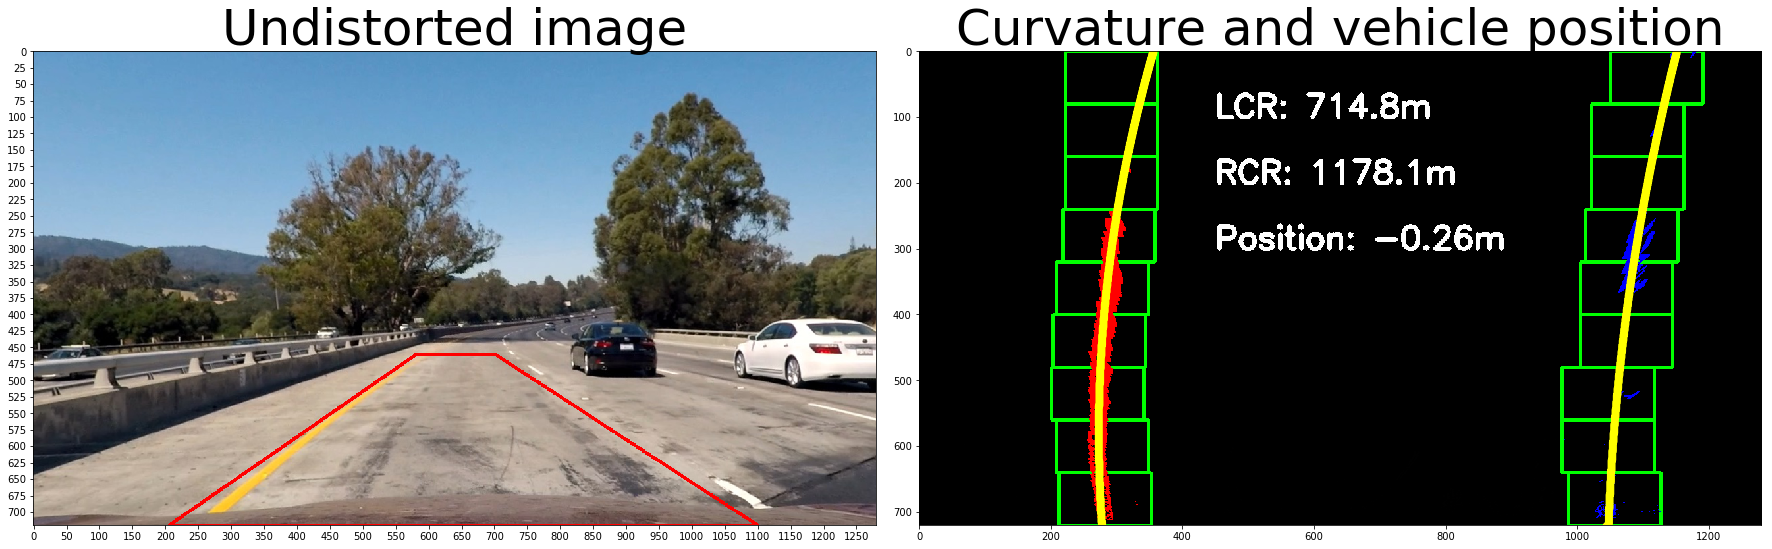

In [24]:
left_curverad, right_curverad, distance_from_center = curvature_position_estimation(binary_warped, left_fit_cr, right_fit_cr, left_x, right_x)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )


# Plotting undistorted image and warped image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
f.tight_layout()

ax1.set_title('Undistorted image', fontsize=50)
ax1.set_xticks(np.arange(0, undist.shape[1], step=50))
ax1.set_yticks(np.arange(0, undist.shape[0], step=25))
ax1.imshow(undist)



# Text visualization parameters
fontFace=cv2.FONT_HERSHEY_SIMPLEX
fontScale= 1.6
color = (255,255,255)
lineType = 5

#Left lane curvature - LCR
cv2.putText(out_img, 'LCR: {0:.1f}'.format(left_curverad)+'m', (450,100), fontFace, fontScale, color, lineType) 
#Right lane curvature - RCR
cv2.putText(out_img, 'RCR: {0:.1f}'.format(right_curverad)+'m', (450,200),fontFace, fontScale, color, lineType) 
# Vehicle position from the lanes midpoint - Positive values indicate to the right, negative to the left of
# the lanes midpoint
cv2.putText(out_img, 'Position: {0:.2f}'.format(distance_from_center)+'m', (450,300),fontFace, fontScale, color, lineType) 

ax2.set_title('Curvature and vehicle position', fontsize= 50)
# Plots the left and right polynomials on the lane lines
ax2.plot(left_fitx, ploty, linewidth=8, color='yellow')
ax2.plot(right_fitx, ploty, linewidth=8,color='yellow')
ax2.imshow(out_img)
plt.subplots_adjust(left = 0., right = 1, top=0.9, bottom = 0.)
plt.show()

# 7. Draw lanes in the original image

In [25]:
def draw_lanes(undist, warped, Minv, left_fitx, right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    unwarped = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, unwarped, 0.3, 0)

    # resunt final image, value x of left lane at the bottom of image, value x of right lane at the bottom of image
    return result

# Advanced lane finding pipeline (without line tracking)

<Figure size 432x288 with 0 Axes>

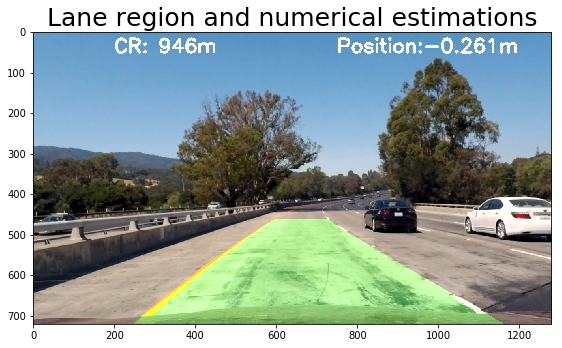

In [26]:
def advanced_pipeline(img):
    
    undist = undistort_image(img, mtx, dist)
    
    img_thresh = threshold_function(undist)
    
    binary_warped, perspective_M, Minv = perspective_transform(img_thresh)
    
    left_fitx, right_fitx, left_fit_cr, right_fit_cr, left_x, right_x, out_img = fit_polynomial(binary_warped)
    
    final= draw_lanes(undist, binary_warped, Minv, left_fitx, right_fitx)
    
    left_curverad, right_curverad, distance_from_center = curvature_position_estimation(binary_warped,left_fit_cr, right_fit_cr, left_x, right_x)
    
    
    
    #Curvature radius mean of left and right lanes
    cv2.putText(final, 'CR: {0:.0f}'.format((left_curverad+right_curverad)/2)+'m', (200,50), fontFace, fontScale, color, lineType) 
    cv2.putText(final, 'Position:{0:.3f}'.format(distance_from_center)+'m', (750,50),fontFace, fontScale, color, lineType) 
    return final 

image = 'test_images/test1.jpg'
img = mpimg.imread(image)

fimage= advanced_pipeline(img)
plt.gcf().clear()

# Plotting undistorted image and warped image
f, (ax1) = plt.subplots(1, 1, figsize=(12,4.5))
f.tight_layout()
ax1.set_title('Lane region and numerical estimations', fontsize= 25)
ax1.imshow(fimage)
plt.subplots_adjust(left = 0., right = 1, top=0.9, bottom = 0.)
plt.show()


# Processing video

In [27]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [28]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # DONE: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    # Use mode=0 to get raw lines as output over the original image. mode = 1 will offer two solid lines instead
    result = advanced_pipeline(image)
    return result

In [ ]:
input = 'project_video.mp4'

output ='estimation_output_project_video.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip(input)
output_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)
plt.gcf().clear()

[MoviePy] >>>> Building video estimation_output_project_video.mp4
[MoviePy] Writing video estimation_output_project_video.mp4


 10%|███████▌                                                                       | 121/1261 [01:45<16:48,  1.13it/s]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

# Advanced lane finding pipeline (with line tracking) and prior/posterior lane detection

In this section I will create a Line class to track the lanes in different frames and operate with data stored over time

In [ ]:
# Define a class to receive the characteristics of each line detection
class Line():
    '''
    Line lane class. Stored the main attributes of the line abstraction and defines
    useful methods to process the line lanes in different frames
    '''
    def __init__(self, lane_type, buffer_size):
        
        # was the line detected in the last iteration?
        self.detected = False  
        
        # x values of the last n fits of the line
        self.recent_xfitted = [[0]]*buffer_size
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients of the last n iterations
        self.recent_fit = [np.array([0,0,0])]*buffer_size  
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None 
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        #number of iterations where data is going to be stored
        self.buffer_size = buffer_size
        #lane type
        if lane_type in ['left', 'right']:
            self.lane_type = lane_type
        else:
            raise Exception('Incorrect lane type.')
        #current index to store data in buffer
        self.current_index = 0
        #indicated when the buffer is full of data
        self.buffer_full = False
    

    # Find a set of pixels part of the left and right lane when no previous lanes have been identified
    def find_lane_pixels_prior(self, binary_warped):
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        if self.lane_type == 'left':
            x_base = np.argmax(histogram[:midpoint])
        elif self.lane_type == 'right':
            x_base = np.argmax(histogram[midpoint:]) + midpoint

        # HYPERPARAMETERS
        # Choose the number of sliding windows
        nwindows = 9
        # Set the width of the windows +/- margin
        margin = 80
        # Set minimum number of pixels found to recenter window
        minpix = 40

        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated later for each window in nwindows
        x_current = x_base

        # Create empty lists to receive left and right lane pixel indices
        lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            ### 1. Find the four boundaries of the left and right window ###
            win_x_low = x_current - margin 
            win_x_high = x_current + margin  
 

            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_x_low,win_y_low),
            (win_x_high,win_y_high),(0,255,0), 4) 

            ### 2. Identify the nonzero pixels in x and y within the window ###
            good_inds = []

            for i in range(len(nonzerox)):

                if nonzerox[i]> binary_warped.shape[1]:
                    print(i, nonzerox[i])
                    continue
                # Add nonzero pixels within the windows in left line
                if (nonzerox[i]<win_x_high and nonzerox[i]>=win_x_low) and \
                    (nonzeroy[i]<win_y_high and nonzeroy[i]>=win_y_low):    
                    good_inds += [i]

            # Append these indices to the lists
            lane_inds.append(good_inds)

            ### 3. If you found > minpix pixels, recenter next window ###
            ### (`x_current`) on their mean position ###
            n = 0
            x_sum = 0
            for i in good_inds:
                n +=  1
                x_sum += nonzerox[i]
            if n > minpix:
                x_current =  x_sum//n


        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            lane_inds = np.concatenate(lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            print('Something went wrong with the concatenation step!\n')
            self.detected = False
            pass

        # Extract left and right line pixel positions
        x = nonzerox[np.uint(lane_inds)]
        y = nonzeroy[np.uint(lane_inds)] 
      
        # Fit new polynomials
        fitx, ploty, fit, fit_cr, x_lane ,out_img = self.fit_polynomial(binary_warped,out_img, x , y)
        
        # Updates basic information about the lane
        self.detected = True
        
        self.recent_xfitted[self.current_index] = fitx
        self.recent_fit[self.current_index] = np.array(fit)
        self.diffs = self.recent_fit[self.current_index] - self.recent_fit[self.current_index-1]
        
        self.ally = ploty
        self.allx = fitx
        
        if self.buffer_full:
            self.bestx = np.sum(self.recent_xfitted,0)//self.buffer_size
            self.best_fit = np.sum(self.recent_fit,0)//self.buffer_size
        else:
            self.bestx = np.sum(self.recent_xfitted,0)//(self.current_index+1)
            self.best_fit = np.sum(self.recent_fit,0)//(self.current_index+1)
            
        self.current_index += 1
        if (self.current_index == self.buffer_size):
            self.current_index = 0
            self.buffer_full = True
        
        return fitx, ploty, fit,  fit_cr, x_lane ,out_img
        #return self.bestx, ploty, self.best_fit,  fit_cr, x_lane ,out_img
    
    # Find a set of pixels part of the left and right lane when previous lanes have been identified
    def find_lane_pixels_posterior(self, binary_warped):
        
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        
        # margin of exploration of lane lines from the previous polynomial fit
        margin = 100
        
        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        ### Set the area of search based on activated x-values ###
        ### within the +/- margin of our polynomial function ###
        ### Hint: consider the window areas for the similarly named variables ###
        ### in the previous quiz, but change the windows to our new search area ###
        margin_min = self.recent_fit[self.current_index-1][0]*nonzeroy**2+self.recent_fit[self.current_index-1][1]*nonzeroy+self.recent_fit[self.current_index-1][2] - margin
        margin_max = self.recent_fit[self.current_index-1][0]*nonzeroy**2+self.recent_fit[self.current_index-1][1]*nonzeroy+self.recent_fit[self.current_index-1][2] + margin
        lane_inds = ((nonzerox >= margin_min) & (nonzerox < margin_max)).nonzero()[0]

        
        # Again, extract line pixel positions
        x = nonzerox[np.uint(lane_inds)]
        y = nonzeroy[np.uint(lane_inds)] 
        
        # Fit new polynomials
        fitx, ploty, fit, fit_cr, x_lane ,out_img = self.fit_polynomial(binary_warped, out_img, x , y)
        
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        line_window1 = np.array([np.transpose(np.vstack([fitx-margin, ploty]))])
        line_window2 = np.array([np.flipud(np.transpose(np.vstack([fitx+margin, 
                                  ploty])))])
        line_pts = np.hstack((line_window1, line_window2))        
        
        cv2.fillPoly(window_img, np.int_([line_pts]), (0,255, 0))
        
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        
        # Updates basic information about the lane
        self.detected = True
        
        self.recent_xfitted[self.current_index] = fitx
        self.recent_fit[self.current_index] = np.array(fit)
        self.diffs = self.recent_fit[self.current_index] - self.recent_fit[self.current_index-1]
        
        self.ally = ploty
        self.allx = fitx
        
        if self.buffer_full:
            self.bestx = np.sum(self.recent_xfitted,0)//self.buffer_size
            self.best_fit = np.sum(self.recent_fit,0)//self.buffer_size
        else:
            self.bestx = np.sum(self.recent_xfitted,0)//(self.current_index+1)
            self.best_fit = np.sum(self.recent_fit,0)//(self.current_index+1)
            
        self.current_index += 1
        if (self.current_index == self.buffer_size):
            self.current_index = 0
            self.buffer_full = True
        
        return fitx, ploty, fit,  fit_cr, x_lane ,result
        #return self.bestx, ploty, self.best_fit,  fit_cr, x_lane ,out_img
    
    #Fit a set of pixel coordinates found in a image to a 2nd degree polynomial
    def fit_polynomial(self, binary_warped, out_img, x, y):
        
        
        # Define conversions in x and y from pixels to meters in the warped space 
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/750 # meters per pixel in x dimension

        ### 4. Fit a second order polynomial to each using `np.polyfit` ###
        fit = np.polyfit(y, x, 2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        try:
            fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            fitx = 1*ploty**2 + 1*ploty

        fit_cr = np.polyfit(ym_per_pix*ploty, xm_per_pix*fitx, 2)
        
        # Here we calculate the lane x coordinate at the bottom of the undistorted image
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        warp = np.dstack((warp_zero, warp_zero, warp_zero))
        
        
        fitx = np.uint(np.abs(fitx))
        # Get the indices for which the fix <= limit
        indices = np.argwhere(fitx < binary_warped.shape[1])
    
        warp[np.uint(ploty[indices]),fitx[indices]] = [0,255,0]

         # Warp the blank back to original image space using inverse perspective matrix (Minv)
        unwarped = cv2.warpPerspective(warp, Minv, (undist.shape[1], undist.shape[0])) 

        single_unwarped = unwarped[:,:,1]
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = single_unwarped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Get the indices fro which the y value is max in the binary image
        max_y_indices = np.argwhere(nonzeroy == np.amax(nonzeroy))
        # Values of x at the bottom of the image in the region between the lanes
        xvals = nonzerox[max_y_indices]
        
        if self.lane_type =='left':
            x_lane = np.min(xvals)
        elif self.lane_type == 'right':
            x_lane = np.max(xvals)
        
        ## Visualization ##
        window_img = np.zeros_like(out_img)    
        
        # Color in lane line pixels
        if self.lane_type =='left':
            out_img[y, x] = [255, 0, 0]
        elif self.lane_type == 'right':
            out_img[y, x] = [0, 0, 255]
        ## End visualization steps ##
        
        # Plot the polynomial lines onto the image
        #plt.plot(fitx, ploty, color='yellow')

        return fitx, ploty, fit, fit_cr, x_lane, out_img 
        
        


## Sanity check

Our goal here is to check whether the lane lines are close to parallel, have a similar curvature and are separated by the right distance (should be around 3.7 meters)

In [ ]:
def sanity_check(left_fit, right_fit, left_curverad, right_curverad, left_x_lane, right_x_lane):
    
    check_failed = False
    
    parallel_check = np.sqrt((left_fit[0]-right_fit[0])**2 + (left_fit[1]-right_fit[1])**2)
    print('Parallel indicator: {0:.2f}'.format(parallel_check))
    if parallel_check > 0.5:
        check_failed = True
        
    curvature_rl_ratio = right_curverad/left_curverad
    print('Curvature radius ratio: {0:.2f}'.format(curvature_rl_ratio))
    if ((curvature_rl_ratio > 5) | (curvature_rl_ratio < 0.2)):
        check_failed = True
    xm_per_pix_cam = 3.7/(1100-206) # meters per pixel in x dimension in camera space
    horizontal_distance = (right_x_lane-left_x_lane)* xm_per_pix_cam
    print('Horizontal separation of lanes: {0:.2f}m'.format(horizontal_distance))
    if np.abs(horizontal_distance-3.7) > 1:
        check_failed = True
    return check_failed

    

In [ ]:
def reset_values():
    left_lane.detected = False
    right_lane.detected = False
    # x values of the last n fits of the line
    left_lane.recent_xfitted = [[0]]*left_lane.buffer_size
    right_lane.recent_xfitted = [[0]]*left_lane.buffer_size
    #average x values of the fitted line over the last n iterations
    left_lane.bestx = None
    right_lane.bestx = None 
    #polynomial coefficients of the last n iterations
    left_lane.recent_fit = [np.array([0,0,0])]*left_lane.buffer_size 
    right_lane.recent_fit = [np.array([0,0,0])]*left_lane.buffer_size
    #polynomial coefficients averaged over the last n iterations
    left_lane.best_fit = None
    right_lane.best_fit = None
    #current index to store data in buffer
    left_lane.current_index = 0
    right_lane.current_index = 0
    #indicated when the buffer is full of data
    left_lane.buffer_full = False
    right_lane.buffer_full = False

## Testing the Line class

In [ ]:
left_lane = Line('left',10)
right_lane = Line('right', 10)

t0 = time.time()

fitx, ploty, fit, fit_cr, x_lane ,result = left_lane.find_lane_pixels_prior(binary_warped)

fitx2, ploty2, fit2, fit_cr2, x_lane2 ,result2 = right_lane.find_lane_pixels_prior(binary_warped)

t1 = time.time()

print('Duration of find lane pixels prior: {0:.3f}'.format(t1-t0))

# Plotting undistorted image and warped image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))

f.tight_layout()
ax1.set_title('Left lane', fontsize=50)
ax1.plot(fitx, ploty, linewidth=8, color='yellow')
ax1.imshow(result)
ax2.set_title('Right lane', fontsize= 50)
ax2.plot(fitx2, ploty, linewidth=8, color='yellow')
ax2.imshow(result2)
plt.subplots_adjust(left = 0., right = 1, top=0.9, bottom = 0.)

plt.show()

t0 = time.time()

fitx, ploty, fit, fit_cr, x_lane ,result = left_lane.find_lane_pixels_posterior(binary_warped)

fitx2, ploty2, fit2, fit_cr2, x_lane2 ,result2 = right_lane.find_lane_pixels_posterior(binary_warped)

t1 = time.time()

print('Duration of find lane pixels posterior: {0:.3f}'.format(t1-t0))
# Plotting undistorted image and warped image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
f.tight_layout()
ax1.set_title('Left lane', fontsize=50)
ax1.plot(fitx, ploty, linewidth=8, color='yellow')
ax1.imshow(result)
ax2.set_title('Right lane', fontsize= 50)
ax2.plot(fitx2, ploty, linewidth=8, color='yellow')
ax2.imshow(result2)
plt.subplots_adjust(left = 0., right = 1, top=0.9, bottom = 0.)
plt.show()


## Pipeline using the line class

In [ ]:
fail_count = 0

def advanced_pipeline_improved(img):
    
    global fail_count
    
    undist = undistort_image(img, mtx, dist)
    
    img_thresh = threshold_function(undist)
    
    binary_warped, perspective_M, Minv = perspective_transform(img_thresh)
    
    if left_lane.detected & right_lane.detected:
        left_fitx, ploty, left_fit, left_fit_cr, left_x_lane ,out_img = left_lane.find_lane_pixels_posterior(binary_warped)
        right_fitx, ploty, right_fit, right_fit_cr, right_x_lane ,out_img2 = right_lane.find_lane_pixels_posterior(binary_warped)
    else:
        left_fitx, ploty, left_fit, left_fit_cr, left_x_lane ,out_img = left_lane.find_lane_pixels_prior(binary_warped)
        right_fitx, ploty, right_fit, right_fit_cr, right_x_lane ,out_img2 = right_lane.find_lane_pixels_prior(binary_warped)
    
    final= draw_lanes(undist, binary_warped, Minv, left_fitx, right_fitx)
    
    left_curverad, right_curverad, distance_from_center = curvature_position_estimation(binary_warped,left_fit_cr, right_fit_cr, left_x_lane, right_x_lane)
    
    insanity = sanity_check(left_fit, right_fit, left_curverad, right_curverad, left_x_lane, right_x_lane)
    
    if insanity:
        fail_count += 1
        left_lane.current_index -= 1
        right_lane.current_index -= 1
        if fail_count>5:
            fail_count = 0
            reset_values()
            
    #Curvature radius mean of left and right lanes
    cv2.putText(final, 'CR: {0:.1f}'.format((left_curverad+right_curverad)/2)+'m', (50,50), fontFace, fontScale, color, lineType) 
    # Position of the vehicle respect to the center of the lane. Negative indicates the vehicle is to the left, positive to the right
    cv2.putText(final, 'Position:{0:.3f}'.format(distance_from_center)+'m', (450,50),fontFace, fontScale, color, lineType) 

    return final

left_lane = Line('left',10)
right_lane = Line('right', 10)

image = 'test_images/test5.jpg'
img = mpimg.imread(image)

t0 = time.time()

fimage= advanced_pipeline_improved(img)
plt.gcf().clear()
plt.imshow(fimage)

t1 = time.time()

print('Time duration of one pipeline pass: {0:.3f}'.format(t1-t0))

In [ ]:
left_lane = Line('left', 10)
right_lane = Line('right', 10)
fail_count = 0

def process_image_improved(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    result = advanced_pipeline_improved(image)
    return result

In [ ]:
input = 'project_video.mp4'

output ='improved_estimation_output_project_video.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip2 = VideoFileClip(input).subclip(17,26)
output_clip2 = clip2.fl_image(process_image_improved) #NOTE: this function expects color images!!
%time output_clip2.write_videofile(output, audio=False)
plt.gcf().clear()